# MNIST with ipcmagic and TensorFlow-2.3

In [1]:
import ipcmagic
import ipyparallel as ipp

%ipcluster start -n 2 --mpi

rc = ipp.Client()
rc.ids

IPCluster is ready! (6 seconds)


[0, 1]

In [2]:
%%px
import os
import math
import json
import numpy as np

import tensorflow as tf
tf.__version__

Out[0:1]: '2.3.0'

Out[1:1]: '2.3.0'

In [3]:
%%px
import socket
socket.gethostname(), tf.config.list_physical_devices('GPU')

Out[0:2]: 
('nid06661',
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

Out[1:2]: 
('nid06662',
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [4]:
%%px
# generally MultiWorkerMirroredStrategy requires 'TF_CONFIG' to be set, but in our case
# SlurmClusterResolver takes care of all the configuration
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
    cluster_resolver=tf.distribute.cluster_resolver.SlurmClusterResolver(),
    communication=tf.distribute.experimental.CollectiveCommunication.NCCL,
)

# os.environ['TF_CONFIG'] = json.dumps({
#     'cluster': {
#         'worker': [f"{os.environ['SLURM_JOB_NODELIST'][:4]}{node}:8888"
#                    for node in os.environ['SLURM_JOB_NODELIST'][5:-1].split('-')]
#     },
#     'task': {'type': 'worker', 'index': os.environ['SLURM_NODEID']}
# })
# os.environ['TF_CONFIG']

In [5]:
%%px
num_workers = int(os.environ['SLURM_NNODES'])
node_id = int(os.environ['SLURM_NODEID'])

per_worker_batch_size = 128

# Here the batch size scales up by number of workers since 
# `tf.data.Dataset.batch` expects the global batch size.
batch_size = per_worker_batch_size * num_workers

learning_rate = 1e-4 * num_workers

node_id, per_worker_batch_size, learning_rate

Out[0:4]: (0, 128, 0.0002)

Out[1:4]: (1, 128, 0.0002)

In [6]:
%%px
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

train_size = len(y_train)
valid_size = len(y_test)

# The `x` arrays are in uint8 and have values in the range [0, 255].
# We need to convert them to float32 with values in the range [0, 1]
train_dataset = (tf.data.Dataset
                   .from_tensor_slices((x_train / np.float32(255), y_train.astype(np.int32)))
#                    .shuffle(train_size, seed=42)
                   .repeat()
                   .batch(batch_size, drop_remainder=True))

valid_dataset = (tf.data.Dataset
                   .from_tensor_slices((x_test / np.float32(255), y_test.astype(np.int32)))
                   .batch(batch_size, drop_remainder=False))

# In multi-worker training with MultiWorkerMirroredStrategy, sharding the dataset
# is needed to ensure convergence and performance. However, note that in code here,
# the datasets are directly passed to model.fit() without needing to shard; this is
# because tf.distribute.Strategy API takes care of the dataset sharding automatically.

train_size, valid_size

Out[0:5]: (60000, 10000)

Out[1:5]: (60000, 10000)

[stdout:0] (256, 28, 28) tf.Tensor([7 2 1 0 4 1 4 9 5 9], shape=(10,), dtype=int32)
[stdout:1] (256, 28, 28) tf.Tensor([7 2 1 0 4 1 4 9 5 9], shape=(10,), dtype=int32)


[output:0]

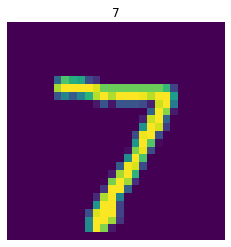

[output:1]

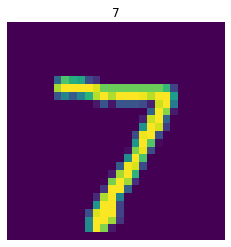

In [7]:
%%px
# show first image on each node
for images, labels in valid_dataset.take(1):
    print(images.shape, labels[:10])
    from matplotlib import pyplot as plt
    plt.imshow(images[0])
    plt.axis('off')
    plt.title(str(labels[0].numpy()))

# the batch is actually the same in both nodes
# the sharding happens within model.fit(), which uses strategy.experimental_distribute_dataset(dataset)

[stdout:0] (128, 28, 28) tf.Tensor([7 2 1 0 4 1 4 9 5 9], shape=(10,), dtype=int32)
[stdout:1] (128, 28, 28) tf.Tensor([8 5 6 6 5 7 8 1 0 1], shape=(10,), dtype=int32)


[output:0]

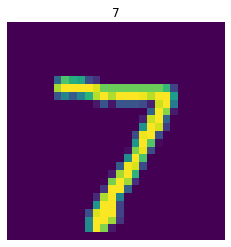

[output:1]

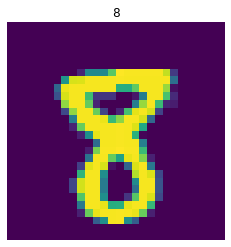

In [8]:
%%px
# show first image on each node (from the sharded batch)
for images, labels in strategy.experimental_distribute_dataset(valid_dataset.take(1)):
    print(images.shape, labels[:10])
    from matplotlib import pyplot as plt
    plt.imshow(images[0])
    plt.axis('off')
    plt.title(str(labels[0].numpy()))

In [9]:
%%px
# Keras' `model.fit()` trains the model with specified number of steps and epochs across all nodes
steps_per_epoch = train_size // batch_size
validation_steps = math.ceil(valid_size / batch_size)
print(f'Training for {steps_per_epoch} steps per epoch across {num_workers} nodes')

[stdout:0] Training for 234 steps per epoch across 2 nodes
[stdout:1] Training for 234 steps per epoch across 2 nodes


In [10]:
%%px
def build_and_compile_cnn_model(learning_rate=learning_rate):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Reshape(target_shape=(28, 28, 1)), # Convolutional layers expect a channel dimension

        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(name='bn0'),

        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(name='bn1'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10),
    ])
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
        metrics=['accuracy'])

    model.summary()
    return model


with strategy.scope():
    # Model building/compiling need to be within `strategy.scope()`.
    multi_worker_model = build_and_compile_cnn_model()

[stdout:0] 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 7, 7, 12

In [11]:
%%px
fit = multi_worker_model.fit(train_dataset,
                             epochs=3,
                             steps_per_epoch=steps_per_epoch,
                             validation_data=valid_dataset,
                             validation_steps=validation_steps,
                            )

[stdout:0] 
Epoch 1/3
234/234 [==============================] - 3s 11ms/step - loss: 0.5180 - accuracy: 0.8513 - val_loss: 1.6555 - val_accuracy: 0.3721
Epoch 2/3
234/234 [==============================] - 1s 6ms/step - loss: 0.2109 - accuracy: 0.9424 - val_loss: 0.4602 - val_accuracy: 0.8896
Epoch 3/3
234/234 [==============================] - 1s 6ms/step - loss: 0.1625 - accuracy: 0.9556 - val_loss: 0.1583 - val_accuracy: 0.9614
[stdout:1] 
Epoch 1/3
234/234 [==============================] - 3s 11ms/step - loss: 0.5180 - accuracy: 0.8513 - val_loss: 1.6555 - val_accuracy: 0.3721
Epoch 2/3
234/234 [==============================] - 1s 6ms/step - loss: 0.2109 - accuracy: 0.9424 - val_loss: 0.4602 - val_accuracy: 0.8896
Epoch 3/3
234/234 [==============================] - 1s 6ms/step - loss: 0.1625 - accuracy: 0.9556 - val_loss: 0.1583 - val_accuracy: 0.9614


### Inspect BatchNorm Layer

In [12]:
%%px
# Batch Normalization statistics (both mean and variance)
# are slightly different due to the data sharding and sample noise
bn = multi_worker_model.get_layer('bn0')
bn.moving_mean[:10]

Out[0:11]: 
<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.02218286, 0.03348842, 0.01080995, 0.01040373, 0.0381533 ,
       0.08240218, 0.05138135, 0.0983244 , 0.03733211, 0.08589105],
      dtype=float32)>

Out[1:11]: 
<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.02225318, 0.03346518, 0.01085443, 0.01036676, 0.03839069,
       0.08291662, 0.05157949, 0.09885009, 0.03739602, 0.08639947],
      dtype=float32)>

In [13]:
%ipcluster stop

#### 